# PIPELINE DE INGESTÃO E PROCESSAMENTO DE DADOS

## Introdução e Objetivos

Este projeto tem como objetivo desenvolver um **pipeline de ingestão e processamento de dados** utilizando a AWS Price List API para coleta de informações de preços do serviço *Amazon EC2 (Elastic Compute Cloud)*.

A partir dos dados obtidos, é realizado um pré-processamento e tratamento estatístico, incluindo análise exploratória, detecção e tratamento de outliers, e transformação de variáveis para posterior modelagem.

O foco principal é a construção de um **modelo de regressão capaz de prever o custo por hora de instâncias EC2 On-Demand**, considerando diferentes configurações de hardware, regiões e sistemas operacionais.

Esse pipeline possibilita:

    Automação da coleta de dados atualizados diretamente da AWS.

    Limpeza, padronização e enriquecimento das variáveis.

    Comparações de performance de modelos com e sem outliers.

    Geração de insights para otimização de custos em ambientes de nuvem.

Em etapas posteriores, o projeto também pode ser expandido para identificar padrões de preços com técnicas de clusterização e aplicar o pipeline para outros produtos da AWS.

## Extração e Ingestão de Dados da AWS

Nesta etapa, realizamos a **extração dos preços do serviço Amazon EC2** utilizando a **AWS Price List API**, com filtros aplicados para **instâncias On-Demand, sistema operacional Linux** e **modalidade Shared**.

A função `run_extract` executa o módulo `extrair_precos_ec2.py`, responsável por automatizar todo o processo de coleta, aplicando os filtros definidos e salvando os resultados no formato adequado para o pipeline.
Essa abordagem garante que os dados utilizados no projeto estejam **atualizados, padronizados e prontos para o pré-processamento**, eliminando a necessidade de downloads manuais e reduzindo riscos de inconsistências.

### Dependências

In [40]:
# importando as dependências iniciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Execução do Pipeline de Extração e Ingestão

Nesta etapa, realizamos a chamada da função `run_extract` para extrair os dados diretamente da AWS Price List API e salvar em um arquivo `.csv`.
Este processo é automatizado, aplicando os filtros definidos (EC2 On-Demand, Linux, Shared) e garantindo que os dados estejam atualizados e prontos para análise.

In [ ]:
# função inicial para extração e ingestão dos dados
from src.extrair_precos_ec2 import run_extract
df = run_extract(out_path="data/custos_aws_ec2_on_demand.csv")
df.head()

In [ ]:
# 1) EC2 bruto por 3 regiões, salvando em Parquet (recomendado)
from src.test.extrair_dados_brutos import extract_pricing_raw
df_raw = extract_pricing_raw(
    service_code="AmazonEC2",
    regions=["us-east-1","sa-east-1","eu-west-1"],
    output_path="data/raw_ec2.parquet",
    output_format="parquet"
)

### Leitura direta do arquivo CSV

Caso já exista um arquivo extraído anteriormente e não seja necessário consultar novamente a API, é possível **carregar os dados diretamente do arquivo salvo**, evitando nova requisição à AWS.

In [3]:
df = pd.read_csv('data/custos_aws_ec2_on_demand.csv')
df.head(5)

,sku,instanceType,family,regionCode,location,operatingSystem,tenancy,vcpu,memory_gb,price_usd_hour,unit,price_per_vcpu,price_per_gb
0,22PCVUMSTSHECWJD,m5d.12xlarge,m5d,us-east-1,US East (N. Virginia),Linux,Shared,48.0,192.0,2.71200,Hrs,0.056500,0.014125
1,25T5FUC5Y3JNGAFA,m7a.8xlarge,m7a,us-east-1,US East (N. Virginia),Linux,Shared,32.0,128.0,1.85472,Hrs,0.057960,0.014490
2,2723Y6XSS36CHBAA,c8gn.24xlarge,c8gn,us-east-1,US East (N. Virginia),Linux,Shared,96.0,192.0,5.68800,Hrs,0.059250,0.029625
3,273THAVM6ZRP8FQ2,r7a.32xlarge,r7a,us-east-1,US East (N. Virginia),Linux,Shared,128.0,1024.0,9.73760,Hrs,0.076075,0.009509
4,286TSEU9NR8JBJBG,r7a.8xlarge,r7a,us-east-1,US East (N. Virginia),Linux,Shared,32.0,256.0,2.43440,Hrs,0.076075,0.009509


Essa abordagem economiza tempo e chamadas à API durante a fase de experimentação e modelagem, especialmente quando os dados não precisam estar em tempo real.

# 1 - Inspeção e entendimento dos dados

In [4]:
# Visulizando o formato
df.shape

(2325, 13)

In [5]:
# Visulizando dimensões
df.dtypes

sku                 object
instanceType        object
family              object
regionCode          object
location            object
operatingSystem     object
tenancy             object
vcpu               float64
memory_gb          float64
price_usd_hour     float64
unit                object
price_per_vcpu     float64
price_per_gb       float64
dtype: object

## Tratamento dos dados numéricos

Removendo valores nulos de price_usd_hour e instanceType

In [86]:
# Remover linhas com price_usd_hour ou instanceType nulos
df = df[df["price_usd_hour"].notna() & df["instanceType"].notna()].copy()

if "family" not in df.columns:
    df["family"] = df["instanceType"].str.split(".").str[0]

df.sample(5)

,sku,instanceType,family,regionCode,location,operatingSystem,tenancy,vcpu,memory_gb,price_usd_hour,unit,price_per_vcpu,price_per_gb
2000,PAF2TCYDAJ8U2C8T,c5d.12xlarge,c5d,eu-west-1,EU (Ireland),Linux,Shared,48.0,96.0,2.6160,Hrs,0.054500,0.027250
2192,VMQFES9RV4Z4HZH4,m7i.metal-48xl,m7i,eu-west-1,EU (Ireland),Linux,Shared,192.0,768.0,10.7856,Hrs,0.056175,0.014044
1471,YPGDFA5SVERSJTYU,c6id.4xlarge,c6id,sa-east-1,South America (Sao Paulo),Linux,Shared,16.0,32.0,1.2516,Hrs,0.078225,0.039113
894,YNW2SYQH36QVDMFC,i7ie.48xlarge,i7ie,us-east-1,US East (N. Virginia),Linux,Shared,192.0,1536.0,24.9504,Hrs,0.129950,0.016244
741,TUXD87XJX6AGYPAD,r7g.medium,r7g,us-east-1,US East (N. Virginia),Linux,Shared,1.0,8.0,0.0536,Hrs,0.053600,0.006700


Realizando limpeza de duplicatas

In [87]:
df.drop_duplicates(inplace=True)
df.shape

(2325, 13)

## Salvando os dados já tratados

O tratamento já foi feito durante o processo de ETL dos dados por meio o módulo èxtrair_precos_ec2.py`e portanto foram ingeridos no pipeline já tratados.

In [89]:
df.to_csv("results/dados_tratados.csv", index=False)
print("✅ dados_tratados.csv salvo!")

✅ dados_tratados.csv salvo!


# 2 - Análise descritiva inicial

## • Análise estatística

In [8]:
# análise estatistica
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vcpu,2325.0,46.312258,68.521475,1.0,4.00000,24.0000,64.000000,896.000000
memory_gb,2325.0,387.787157,1557.363650,0.5,16.00000,96.0000,256.000000,32768.000000
price_usd_hour,2325.0,4.921729,16.984289,0.0,0.36200,1.7100,4.608000,360.986950
price_per_vcpu,2325.0,0.083809,0.060566,0.0,0.05250,0.0680,0.091200,0.593400
price_per_gb,2325.0,0.017963,0.010111,0.0,0.01075,0.0151,0.022719,0.106875


In [9]:
price_region = df.groupby("regionCode")["price_usd_hour"].agg(["min","mean","max"])
price_region

,min,mean,max
regionCode,,,
eu-west-1,0.0046,4.180065,244.40000
sa-east-1,0.0067,5.501450,261.30000
us-east-1,0.0000,5.226179,360.98695


## • Análise de Outliers

#### Identificação e visualização

Gerando boxplot e distribuição de preço por hora para validar outliers

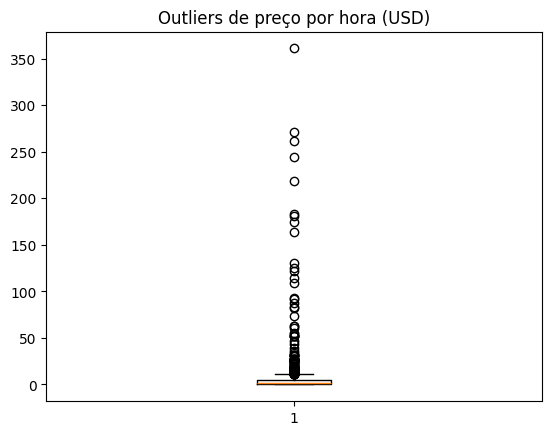

In [11]:
# visualizando boxplot
plt.boxplot(df["price_usd_hour"])
plt.title("Outliers de preço por hora (USD)")
plt.show()

In [12]:
# identificando 1º e 3º quartis
Q1 = df['price_usd_hour'].quantile(0.25)
Q3 = df['price_usd_hour'].quantile(0.75)

print(f"Q1: {Q1}\n")
print(f"Q3: {Q3}\n")

Q1: 0.362

Q3: 4.608



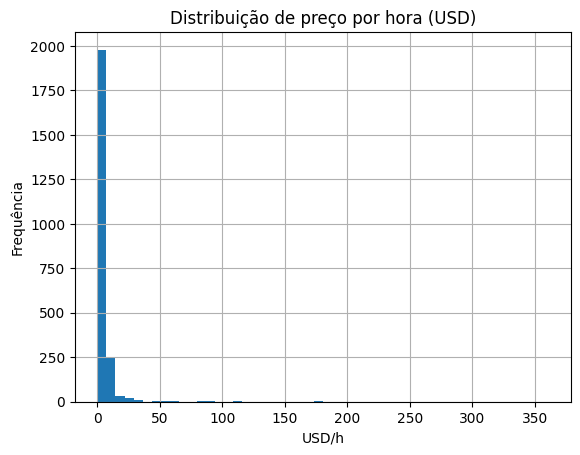

In [ ]:
# plotando gráfico de distribuição
plt.figure()
df["price_usd_hour"].hist(bins=50)
plt.title("Distribuição de preço por hora (USD)")
plt.xlabel("USD/h")
plt.ylabel("Frequência")
plt.show()

In [54]:
# calculando os limites inferior e superior
Q1 = df['price_usd_hour'].quantile(0.25)
Q3 = df['price_usd_hour'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5*IQR
limite_superior = Q3 + 1.5*IQR

print(f"Q1 - 1º Quartil: {Q1}\n")
print(f"Q3 - 3º Quartil: {Q3}\n")
print(f"Limite inferior: {limite_inferior}\n")
print(f"Limite superior: {limite_superior}\n")

Q1 - 1º Quartil: 0.362

Q3 - 3º Quartil: 4.608

Limite inferior: -6.007

Limite superior: 10.977



#### Análise inicial dos preços por hora das instâncias EC2 On-Demand (Linux/Shared)

1. **Concentração de preços baixos**  
   - Tanto no histograma quanto no boxplot, nota-se que a grande maioria das instâncias está na faixa de **0 e 4.61 USD/h**.  
   - Isso indica que, para a maioria dos cenários, o custo de uso é relativamente baixo e previsível.  

2. **Presença significativa de outliers**  
   - Os valores acima do limite superior no boxplot representam instâncias com preços muito superiores à média.  
   - Há casos extremos, chegando a mais de **350 USD/h**, provavelmente relacionados a instâncias de altíssimo desempenho (com muitos vCPUs, grande memória, GPU dedicada, etc.) ou localizadas em regiões de custo elevado.  

3. **Distribuição altamente assimétrica (positivamente enviesada)**  
   - A mediana está muito próxima do valor mínimo, e a cauda longa à direita indica poucos casos com preços extremamente altos.  
   - Esse padrão confirma que os valores altos são raros, mas têm forte impacto nas métricas que dependem da média.  

4. **Implicações práticas**  
   - **Para modelagem preditiva:** outliers podem distorcer modelos lineares e métricas de erro, sendo interessante testar versões com e sem esses valores.  
   - **Para planejamento de custos:** vale identificar e isolar quais instâncias representam esses outliers para avaliar se realmente são necessárias, visto que impactam de forma desproporcional o orçamento.  


## • Detalhamento e estudo dos Outliers

In [55]:
# Filtrando os top 10 outliers com maior preço
top_10_outliers = (df[(df['price_usd_hour']>limite_superior)]
                   .sort_values(by='price_usd_hour', ascending=False)
                   .head(10)
                   )
top_10_outliers

,sku,instanceType,family,regionCode,location,operatingSystem,tenancy,vcpu,memory_gb,price_usd_hour,unit,price_per_vcpu,price_per_gb
43,3J8ZQE6B6HQXNM9B,u7in-32tb.224xlarge,u7in-32tb,us-east-1,US East (N. Virginia),Linux,Shared,896.0,32768.0,360.98695,Hrs,0.402887,0.011016
399,FJFP9RACAVMN8HXV,u7in-24tb.224xlarge,u7in-24tb,us-east-1,US East (N. Virginia),Linux,Shared,896.0,24576.0,270.73128,Hrs,0.302155,0.011016
1365,TFCXUFGE7CZW5ATY,u-18tb1.112xlarge,u-18tb1,sa-east-1,South America (Sao Paulo),Linux,Shared,448.0,18432.0,261.30000,Hrs,0.583259,0.014176
2068,RE5YS2QNCGXJTFZU,u-24tb1.112xlarge,u-24tb1,eu-west-1,EU (Ireland),Linux,Shared,448.0,24576.0,244.40000,Hrs,0.545536,0.009945
367,EDQFZCMZ296MNBZS,u-24tb1.112xlarge,u-24tb1,us-east-1,US East (N. Virginia),Linux,Shared,448.0,24576.0,218.40000,Hrs,0.487500,0.008887
1769,CDZT2C7VCTWBRQV3,u-18tb1.112xlarge,u-18tb1,eu-west-1,EU (Ireland),Linux,Shared,448.0,18432.0,183.30000,Hrs,0.409152,0.009945
109,5EES6SXQYDY6KCHJ,u7in-16tb.224xlarge,u7in-16tb,us-east-1,US East (N. Virginia),Linux,Shared,896.0,16384.0,180.47558,Hrs,0.201424,0.011015
1194,GPTG5JU7J9F5Q86Z,u-12tb1.112xlarge,u-12tb1,sa-east-1,South America (Sao Paulo),Linux,Shared,448.0,12288.0,174.20000,Hrs,0.388839,0.014176
693,S7RW5MZ8Q95Y7MMY,u-18tb1.112xlarge,u-18tb1,us-east-1,US East (N. Virginia),Linux,Shared,448.0,18432.0,163.80000,Hrs,0.365625,0.008887
1079,9S8M8DJFACXGXK8U,u-9tb1.112xlarge,u-9tb1,sa-east-1,South America (Sao Paulo),Linux,Shared,448.0,9216.0,130.65000,Hrs,0.291629,0.014176


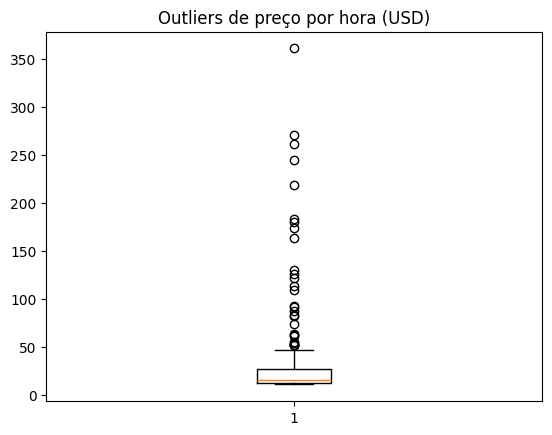

In [56]:
outliers = df[(df['price_usd_hour']>limite_superior)]
# visualizando boxplot
plt.boxplot(outliers["price_usd_hour"])
plt.title("Outliers de preço por hora (USD)")
plt.show()

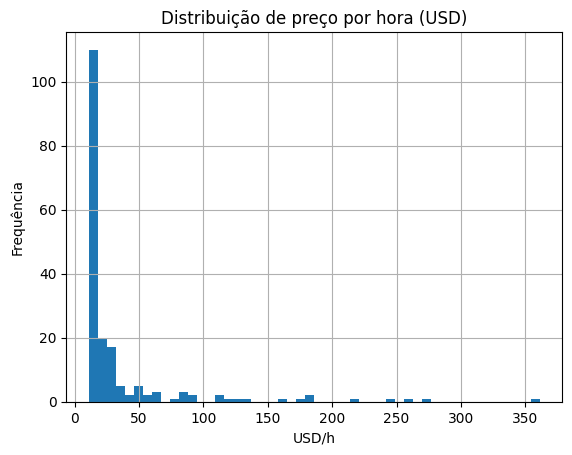

In [57]:
# plotando gráfico de distribuição
plt.figure()
outliers["price_usd_hour"].hist(bins=50)
plt.title("Distribuição de preço por hora (USD)")
plt.xlabel("USD/h")
plt.ylabel("Frequência")
plt.show()

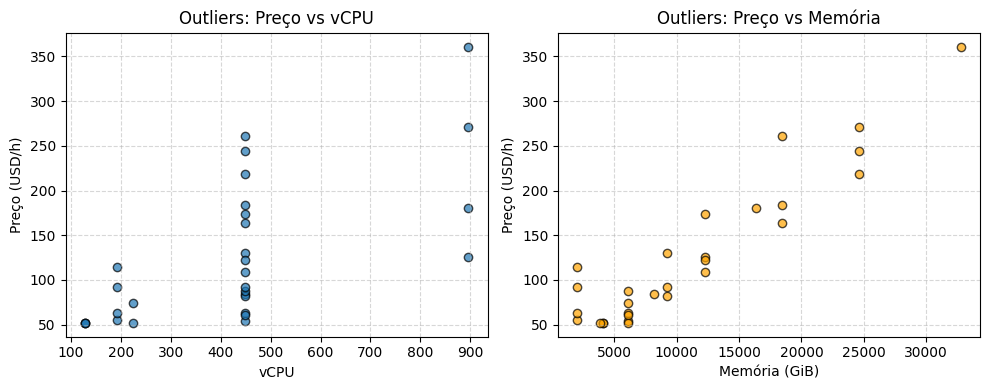

In [58]:
# Calcula limites para considerar outlier
q1 = outliers["price_usd_hour"].quantile(0.25)
q3 = outliers["price_usd_hour"].quantile(0.75)
iqr = q3 - q1
limite_superior = q3 + 1.5 * iqr

# Filtra só outliers
outliers_df = outliers[(outliers['price_usd_hour']>limite_superior)]

# Scatter Preço × vCPU
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(outliers_df['vcpu'], outliers_df['price_usd_hour'], alpha=0.7, edgecolor='k')
plt.xlabel("vCPU")
plt.ylabel("Preço (USD/h)")
plt.title("Outliers: Preço vs vCPU")
plt.grid(True, linestyle='--', alpha=0.5)

# Scatter Preço × Memória
plt.subplot(1,2,2)
plt.scatter(outliers_df['memory_gb'], outliers_df['price_usd_hour'], alpha=0.7, edgecolor='k', color='orange')
plt.xlabel("Memória (GiB)")
plt.ylabel("Preço (USD/h)")
plt.title("Outliers: Preço vs Memória")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

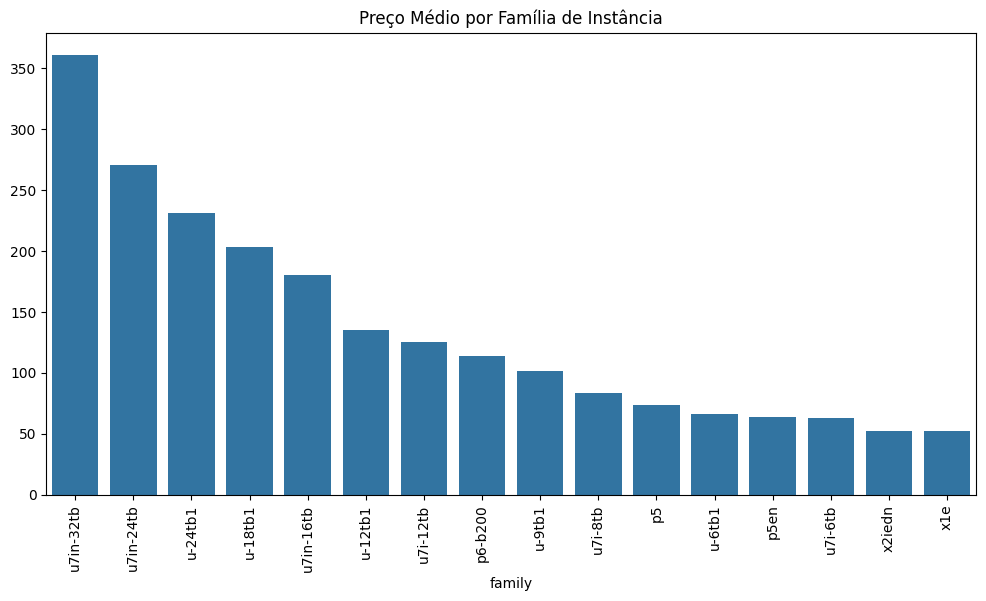

In [61]:
# visualizando preço por familia de instancias

# Preço médio por família
families_price = outliers_df.groupby('family')['price_usd_hour'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=families_price.index, y=families_price.values)
plt.xticks(rotation=90)
plt.title("Preço Médio por Família de Instância")
plt.show()

#### 💡 Insights sobre Outliers de Preço por Família de Instância

A análise do **preço médio por família** dentro do grupo de *outliers* revelou que:

- **Famílias `u` (Ultra Memory)** e **`p` (GPU de alta performance)** lideram com folga os valores mais altos.
  - `u` → instâncias com memória extrema, voltadas para cargas como **SAP HANA** e grandes bancos *in-memory*.
  - `p` → instâncias com GPUs potentes para **treinamento de Machine Learning**, **HPC** e simulações.
- As famílias **`u-`** chegam a ultrapassar **USD 350/hora**, valor que coincide com o ponto mais extremo visto no scatter plot de preço × vCPU.
- Outras famílias caras incluem:
  - `trn` → otimizadas para *deep learning* com AWS Trainium.
  - `x` → alta capacidade de memória para cargas especializadas.
- Famílias generalistas (`m`, `c`, `t`) **não aparecem no topo** dos preços, reforçando que os valores elevados estão ligados a **configurações especializadas e de nicho**.


## • Validando as instâncias de maior preço

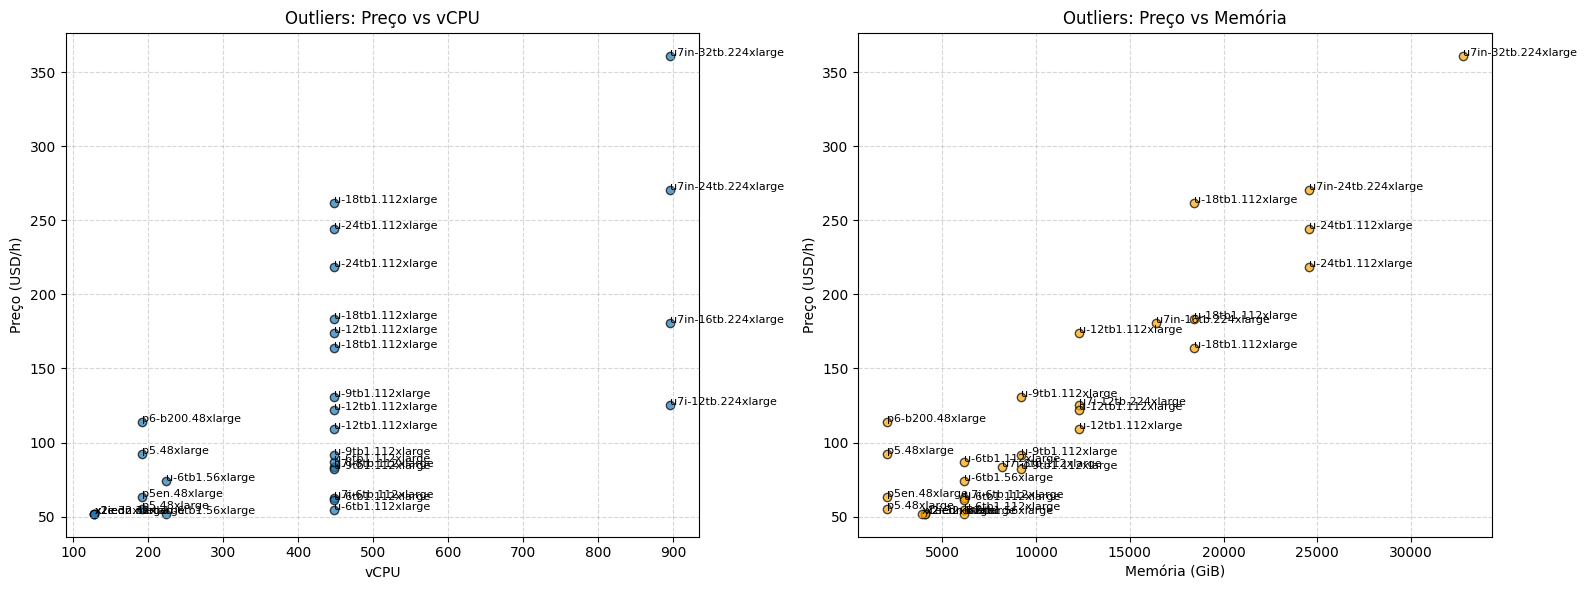

In [63]:
# plotando o gráfico de preço x vcpu x memoria com label das instâncias
def plot_outliers_scatter_labels(df, price_col="price_usd_hour", vcpu_col="vcpu", mem_col="memory_gb", type_col="instanceType"):
    # Limite para definir outlier (IQR)
    q1 = df[price_col].quantile(0.25)
    q3 = df[price_col].quantile(0.75)
    iqr = q3 - q1
    limite_superior = q3 + 1.5 * iqr

    # Filtra apenas outliers
    outliers_df = df[df[price_col] > limite_superior]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Scatter Preço × vCPU com labels
    axes[0].scatter(outliers_df[vcpu_col], outliers_df[price_col], alpha=0.7, edgecolor='k')
    for _, row in outliers_df.iterrows():
        axes[0].text(row[vcpu_col], row[price_col], row[type_col], fontsize=8)
    axes[0].set_xlabel("vCPU")
    axes[0].set_ylabel("Preço (USD/h)")
    axes[0].set_title("Outliers: Preço vs vCPU")
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # Scatter Preço × Memória com labels
    axes[1].scatter(outliers_df[mem_col], outliers_df[price_col], alpha=0.7, edgecolor='k', color='orange')
    for _, row in outliers_df.iterrows():
        axes[1].text(row[mem_col], row[price_col], row[type_col], fontsize=8)
    axes[1].set_xlabel("Memória (GiB)")
    axes[1].set_ylabel("Preço (USD/h)")
    axes[1].set_title("Outliers: Preço vs Memória")
    axes[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()
plot_outliers_scatter_labels(outliers)

In [64]:
# filtrando a tabela com esses valores para melhor visualização
outliers_df = (
        outliers[outliers['price_usd_hour'] > limite_superior]
        .loc[:, ["instanceType", "vcpu", "memory_gb", 'price_usd_hour']]
        .sort_values(by='price_usd_hour', ascending=False)
        .reset_index(drop=True)
    )
outliers_df

,instanceType,vcpu,memory_gb,price_usd_hour
0,u7in-32tb.224xlarge,896.0,32768.0,360.98695
1,u7in-24tb.224xlarge,896.0,24576.0,270.73128
2,u-18tb1.112xlarge,448.0,18432.0,261.30000
3,u-24tb1.112xlarge,448.0,24576.0,244.40000
4,u-24tb1.112xlarge,448.0,24576.0,218.40000
5,u-18tb1.112xlarge,448.0,18432.0,183.30000
6,u7in-16tb.224xlarge,896.0,16384.0,180.47558
7,u-12tb1.112xlarge,448.0,12288.0,174.20000
8,u-18tb1.112xlarge,448.0,18432.0,163.80000
9,u-9tb1.112xlarge,448.0,9216.0,130.65000


## 💡 Insights dos Outliers de maior preço

A análise dos *scatter plots* com rótulos (`instanceType`) mostra que:

- **Topo absoluto de preço**:
  - `u7in-32tb.224xlarge` ultrapassa **USD 350/h**, confirmando o ponto mais extremo do boxplot inicial.
  
- **Cluster de altíssima capacidade** (vCPU ~900, memória 12–24 TiB):
  - `u7in-24tb.224xlarge`
  - `u7in-16tb.224xlarge`
  - `u7in-12tb.224xlarge`

- **Faixa intermediária de preço alto** (vCPU ~448, memória 12–18 TiB):
  - `u6-18tb.112xlarge`
  - `u6-24tb.112xlarge`
  - `u6-12tb.112xlarge`

- **Casos específicos de GPU e HPC**:
  - `p6-b200.48xlarge`
  - `p5.48xlarge`
  - `p5en.48xlarge`
  - Preços entre USD 50 e USD 110/h, ainda considerados outliers frente à média geral.

- **Conclusão**:
  - Os preços mais altos estão concentrados em **famílias ultra memory (`u`)** e **GPU (`p`)**.
  - As instâncias generalistas permanecem fora da faixa de outliers, reforçando que esses valores extremos estão associados a **configurações especializadas**.


# 3 - Análise Comparativa

Preço médio por região

In [38]:
# preço médio por região
price_mean_region = df.groupby("regionCode", as_index=False)["price_usd_hour"].mean().sort_values("price_usd_hour")
price_mean_region

,regionCode,price_usd_hour
0,eu-west-1,4.180065
2,us-east-1,5.226179
1,sa-east-1,5.501450


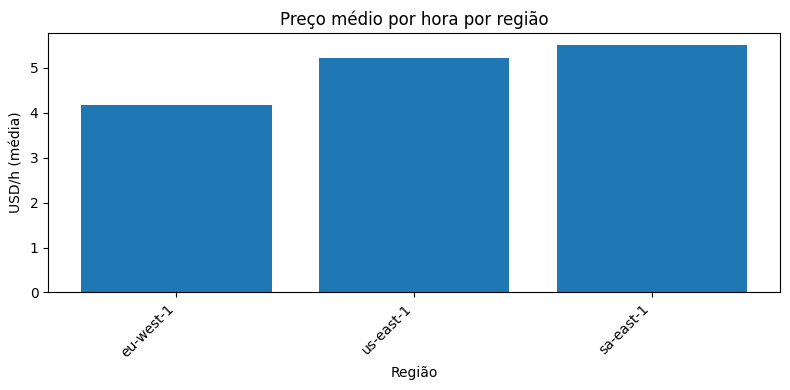

In [40]:
# visualizando preço médio por região
plt.figure(figsize=(8,4))
plt.bar(price_mean_region["regionCode"], price_mean_region["price_usd_hour"])
plt.title("Preço médio por hora por região")
plt.xlabel("Região")
plt.ylabel("USD/h (média)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Top famílias com menor preço/vCPU

In [31]:
top_families_vCPU = (
    df.groupby("family", as_index=False)["price_per_vcpu"].mean()
      .dropna()
      .sort_values("price_per_vcpu")
      .head(12)
)
top_families_vCPU

,family,price_per_vcpu
115,t1,0.022333
119,t4g,0.023250
118,t3a,0.026040
0,a1,0.027151
117,t3,0.028950
116,t2,0.035638
10,c6g,0.040961
17,c7g,0.043519
9,c6a,0.046080
5,c5a,0.046833


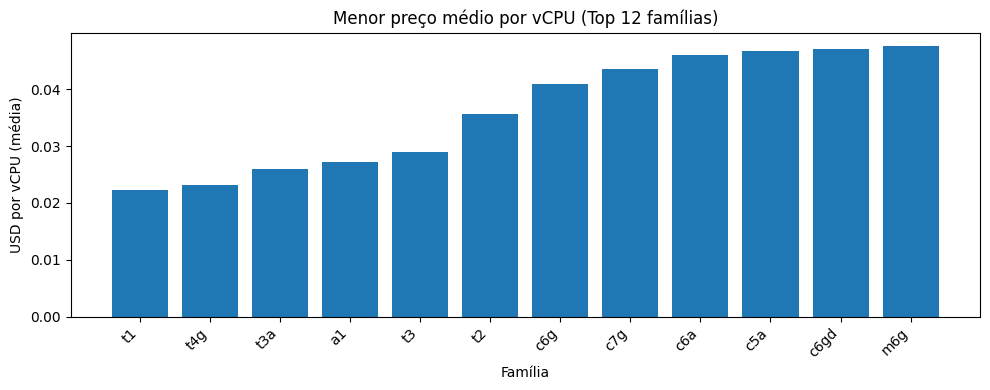

In [ ]:
# visualizando o menor preço médio por vCPU (Top 12 famílias)
plt.figure(figsize=(10,4))
plt.bar(top_families_vCPU["family"], top_families_vCPU["price_per_vcpu"])
plt.title("Menor preço médio por vCPU (Top 12 famílias)")
plt.xlabel("Família")
plt.ylabel("USD por vCPU (média)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Correlações de features

In [ ]:
# verificando matriz de correlação
corr = df.corr(numeric_only=True)
corr

,vcpu,memory_gb,price_usd_hour,price_per_vcpu,price_per_gb
vcpu,1.000000,0.759498,0.780564,0.250792,-0.085143
memory_gb,0.759498,1.000000,0.966009,0.452836,-0.129875
price_usd_hour,0.780564,0.966009,1.000000,0.511467,-0.046009
price_per_vcpu,0.250792,0.452836,0.511467,1.000000,0.149856
price_per_gb,-0.085143,-0.129875,-0.046009,0.149856,1.000000


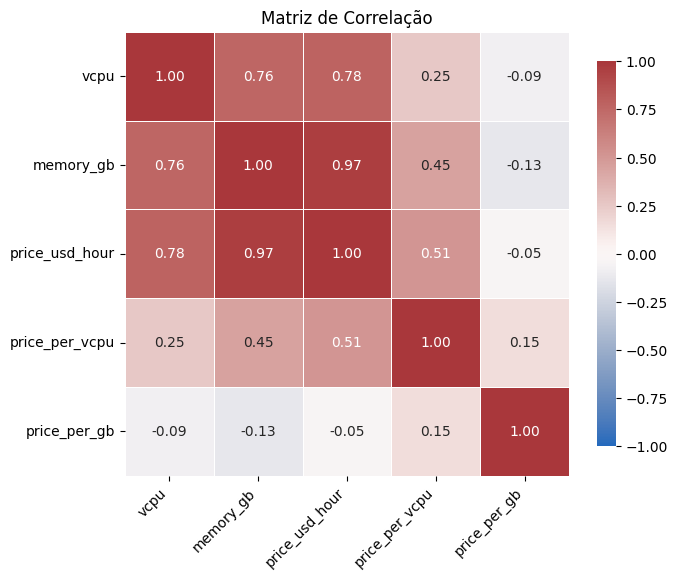

In [ ]:
# plotando matriz de correlação
plt.figure(figsize=(7,6))
sns.heatmap(
    corr, annot=True, fmt=".2f",
    vmin=-1, vmax=1, center=0,
    cmap="vlag", square=True,
    linewidths=.5, cbar_kws={"shrink": .8}
)
plt.title("Matriz de Correlação")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 💡 Insight da Matriz de Correlação

- **Preço/hora (`price_usd_hour`)** apresenta **correlação muito alta com memória (`memory_gb`)** (**0,97**) e também com vCPU (**0,78**).  
  ➡️ Isso indica que o preço é fortemente influenciado pela **quantidade de memória**, mais até do que pelo número de CPUs.  
  Em termos práticos: instâncias com muita RAM tendem a ser significativamente mais caras, mesmo quando o número de vCPUs não cresce proporcionalmente.

- **Preço por vCPU (`price_per_vcpu`)** tem correlação **moderada com `memory_gb` (0,45)** e baixa com `vcpu` (0,25).  
  ➡️ Sugere que, na média, instâncias com mais memória também tendem a ter custo/vCPU maior, mas não é uma relação tão forte quanto a do preço/hora total.

- **Preço por GB (`price_per_gb`)** praticamente **não apresenta correlação** com vCPU ou memória total.  
  ➡️ Isso mostra que a métrica “preço por GB” é muito mais volátil e não segue a mesma lógica linear do preço total — podendo variar bastante entre famílias e configurações.


# Pré-processamento para modelagem

In [65]:
# verificando tipagem dos dados
df.dtypes

sku                 object
instanceType        object
family              object
regionCode          object
location            object
operatingSystem     object
tenancy             object
vcpu               float64
memory_gb          float64
price_usd_hour     float64
unit                object
price_per_vcpu     float64
price_per_gb       float64
dtype: object

In [66]:
# separando dados categóricos e numéricos
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

cat_cols = df.select_dtypes('object').columns.to_list()
num_cols = df.select_dtypes('float').columns.drop('price_usd_hour').to_list()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

# Aplicação do modelo de Regressão (com e sem outliers)

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

df_normal = df[df["price_usd_hour"] <= limite_superior].copy()
df_outlier = df.copy()

In [81]:
def treinar_avaliar(df, titulo):
    # Features e target
    X = df[cat_cols + num_cols].copy()
    y = df["price_usd_hour"].copy()

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelo
    model = Pipeline(steps=[
        ("prep", preprocess),
        ("rf", RandomForestRegressor(n_estimators=300, random_state=42))
    ])

    # Treina
    model.fit(X_train, y_train)

    # Predição
    y_pred = model.predict(X_test)

    # Métricas
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"{titulo} -> R²: {r2:.4f} | RMSE: {rmse:.4f}")

    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k', label='Previsões')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label='Linha Perfeita')

    plt.xlabel("Valor Real (y_test)")
    plt.ylabel("Valor Previsto (y_pred)")
    plt.title(f"Desempenho do {titulo}\nR²={r2:.3f} | MAE={mae:.4f} | RMSE={rmse:.4f}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    return model, {"cenario":titulo,"r2": r2, "rmse": rmse}

Modelo Normal -> R²: 0.9869 | RMSE: 0.5309


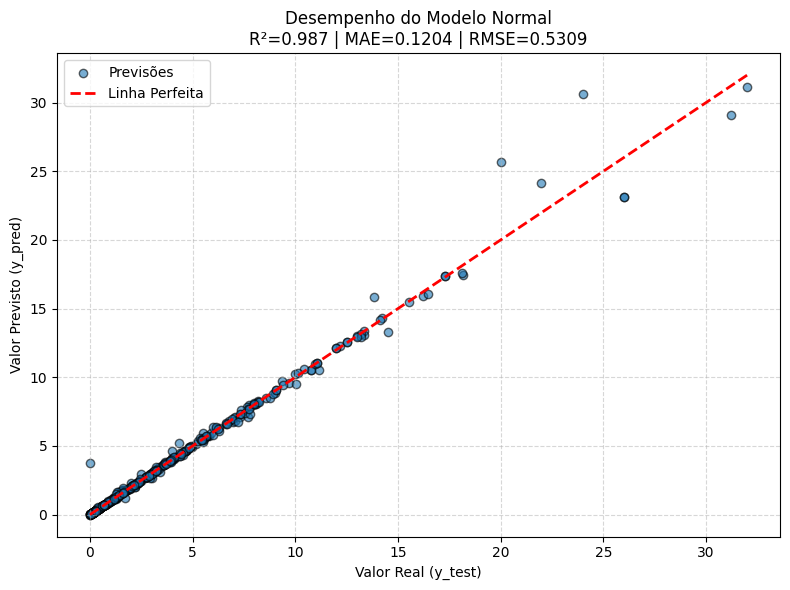

Modelo com Outliers -> R²: 0.9550 | RMSE: 3.8907


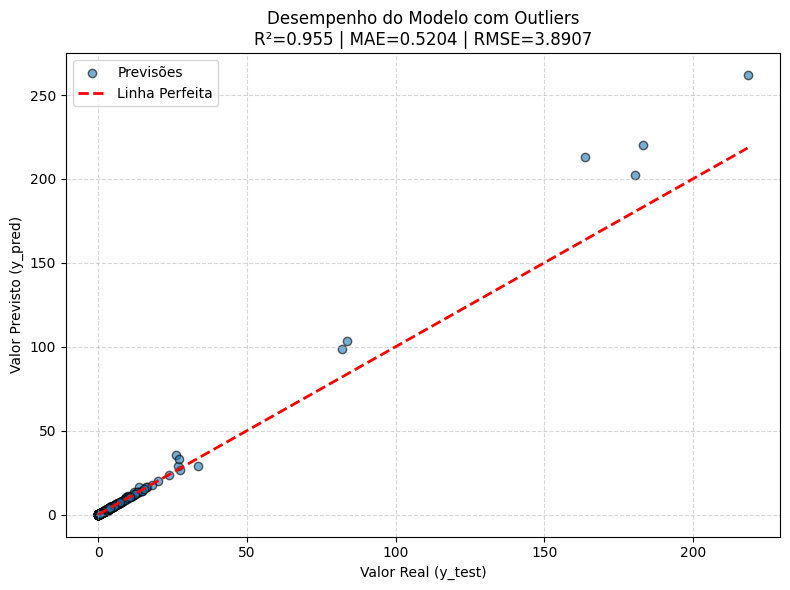

In [82]:
# treinar e avaliar nos dois cenários
modelo_normal, met_normal = treinar_avaliar(df_normal, "Modelo Normal")
modelo_outlier, met_outlier = treinar_avaliar(df_outlier, "Modelo com Outliers")

/tmp/ipykernel_64782/3268884821.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/matheus-borges/Projetos/portifolio_matheus/pipeline_aws_price/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


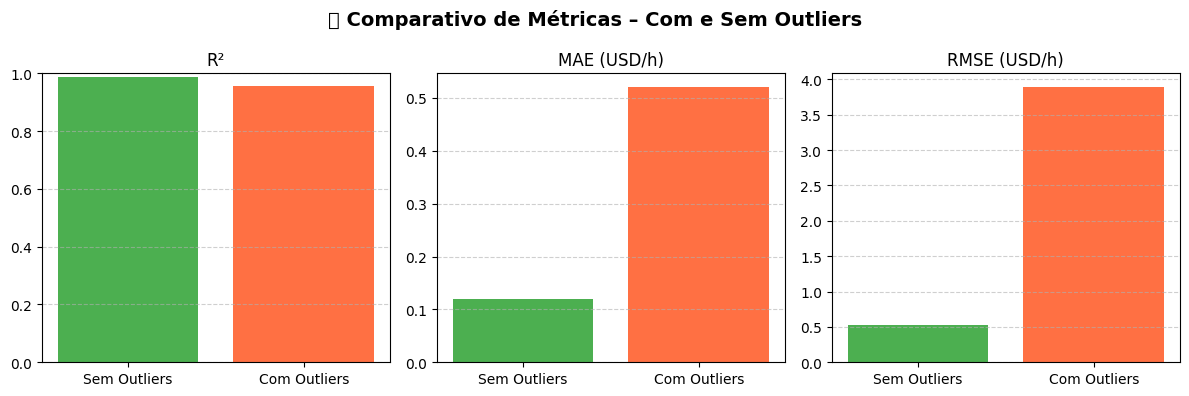

In [83]:
# Dados das métricas
dados = {
    "Cenário": ["Sem Outliers", "Com Outliers"],
    "R²": [0.987, 0.955],
    "MAE": [0.1204, 0.5204],
    "RMSE": [0.5309, 3.8907]
}

df_metricas = pd.DataFrame(dados)

# Plotando gráfico comparativo
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# R²
axes[0].bar(df_metricas["Cenário"], df_metricas["R²"], color=['#4CAF50', '#FF7043'])
axes[0].set_title("R²")
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# MAE
axes[1].bar(df_metricas["Cenário"], df_metricas["MAE"], color=['#4CAF50', '#FF7043'])
axes[1].set_title("MAE (USD/h)")
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# RMSE
axes[2].bar(df_metricas["Cenário"], df_metricas["RMSE"], color=['#4CAF50', '#FF7043'])
axes[2].set_title("RMSE (USD/h)")
axes[2].grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle("📊 Comparativo de Métricas – Com e Sem Outliers", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Salvando resultados

In [84]:
from datetime import datetime

def salvar_metricas(met_normal, met_outlier, path="results/resultados.csv"):
    """
    Espera dicionários de métricas (ex.: {'nome': 'Modelo Normal', 'r2': ..., 'mae': ..., 'rmse': ...}).
    Salva um CSV com colunas padronizadas e qualquer métrica extra que existir.
    """
    # Padroniza chaves mais comuns
    def _row(m):
        return {
            "cenario": m.get("nome") or m.get("modelo") or m.get("cenario") or "desconhecido",
            "r2": m.get("r2"),
            "mae": m.get("mae"),
            "rmse": m.get("rmse"),
            "mape": m.get("mape"),
            "n_train": m.get("n_train"),
            "n_test": m.get("n_test"),
            "timestamp": datetime.utcnow().isoformat(timespec="seconds") + "Z",
            # mantém quaisquer outras métricas adicionais
            **{k: v for k, v in m.items() if k not in {"nome","modelo","cenario","r2","mae","rmse","mape","n_train","n_test"}}
        }

    df = pd.DataFrame([_row(met_normal), _row(met_outlier)])
    df.to_csv(path, index=False)
    print(f"✅ Métricas salvas em: {path}")

In [90]:
import joblib

# Salvar métricas
salvar_metricas(met_normal, met_outlier)

# Salvar modelo
joblib.dump(modelo_normal, "results/modelo_normal.pkl")
print("✅ Modelo salvo em results/modelo_normal.pkl")
joblib.dump(modelo_outlier, "results/modelo_outlier.pkl")
print("✅ Modelo salvo em results/modelo_outlier.pkl")

/tmp/ipykernel_64782/3144492112.py:18: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds") + "Z",


✅ Métricas salvas em: results/resultados.csv
✅ Modelo salvo em results/modelo_normal.pkl
✅ Modelo salvo em results/modelo_outlier.pkl


## 💡 Insight de Negócio – Modelo Normal (sem Outliers)

O modelo treinado com foco em **situações normais de uso**, ou seja, considerando apenas instâncias dentro do padrão de mercado e excluindo configurações de nicho (outliers), apresentou **excelente capacidade preditiva**:

- **R² = 0.987** → Explica 98,7% da variação nos preços para instâncias comuns.
- **MAE = 0.1204** → Erro médio de apenas 12 centavos de dólar por hora.
- **RMSE = 0.5309** → Baixa dispersão dos erros, garantindo previsões consistentes.

### 📈 Valor para o negócio
Esse resultado demonstra que, para a maioria das situações de contratação de instâncias EC2 (uso geral), é possível **estimar o custo com alta precisão**, apoiando:
- **Orçamentação precisa** para projetos em nuvem.
- **Comparação de custo-benefício** entre diferentes tipos de instância e regiões.
- **Suporte à decisão** na escolha da configuração mais econômica para atender uma demanda.

Ao excluir instâncias especializadas de alto desempenho (como famílias `u`, `p`, `trn` e `x`), evitamos distorções causadas por hardware destinado a nichos específicos, garantindo previsões mais estáveis e alinhadas à realidade da maioria dos usuários e empresas.


---

### Modelo com Outliers
Ao incluir as **instâncias especializadas de alto desempenho** no conjunto de treino, o modelo apresentou queda no desempenho:

- **R² = 0.955** → Ainda explica 95,5% da variação, mas com piora em relação ao cenário sem outliers.
- **MAE = 0.5204** → Erro médio mais de 4x maior.
- **RMSE = 3.8907** → Aumento significativo da dispersão dos erros.

**Interpretação:**  
Os outliers representam configurações de hardware altamente específicas, com preços muito acima da média, quebrando o padrão linear entre recursos e custo.  
Isso leva o modelo a **subestimar valores extremos**, reduzindo a precisão geral.

---

### 🚀 Próximos Passos
Como trabalho futuro, será desenvolvido um **modelo específico para previsão de preços de instâncias especializadas**, utilizando algoritmos robustos a outliers, como o **XGBoost**.  
Esse segundo modelo permitirá atender **cargas de trabalho críticas e de nicho** sem comprometer a acurácia obtida no cenário de uso comum.